# Activation Function

Activation functions introduce non-linearity to the neural network. They are used to transform the input signal into the output signal. The output signal is used to make predictions.

In ReLU, the output is 0 if the input is less than 0, and the output is the input if the input is greater than 0. The ReLU function is defined as:
f(x) = max(0, x)

Hidden layer Activation works as follows:
 - the input weights determines the slope of the RELU function. If the input weights are large, the slope of the RELU function is steep. If the input weights are small, the slope of the RELU function is shallow.

 - The bias controls the activation point

 - if we negate the weights, the slope of the RELU function is also negated determining when the neuron should be deactivated

 - connecting this neuron to another neuron and adjusting its bias, the function is shifted vertically(up or down)

 - if we negate the weights of the 2nd neuron, we have a lower and upper bound for the input signal

In [1]:
import numpy as np
def ReLu(input):
    return np.maximum(0, input)


# Creating a Spiral Dataset

In [2]:
np.random.seed(0)
def create_spiral_dataset(num_samples, num_classes, num_dimensions, noise=1):
    X = np.zeros((num_samples*num_classes, num_dimensions))
    y = np.zeros(num_samples*num_classes, dtype='uint8')
    for class_number in range(num_classes):
        ix = range(num_samples*class_number, num_samples*(class_number+1))
        r = np.linspace(0.0, 1, num_samples)  # radius
        t = np.linspace(class_number*4, (class_number+1)*4, num_samples) + np.random.randn(num_samples)*noise  # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = class_number
    return X, y

X, y = create_spiral_dataset(100, 3, 2)

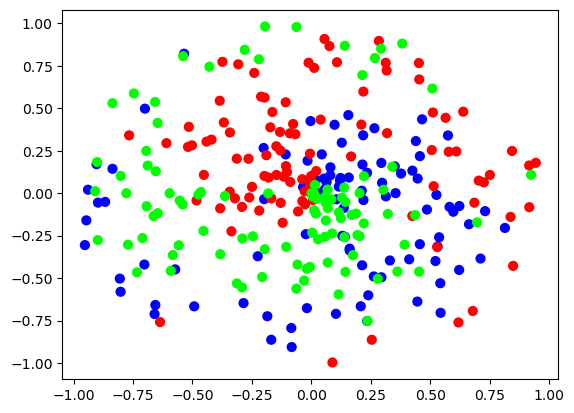

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')

In [4]:
# from 1 - Neuron.ipynb

class Dense_layer:
    
    def __init__(self,n_inputs, n_neurons):
        # note that n_inputs becomes the number of rows and n_neurons becomes the number of columns to avoid transposing the weights
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons) # 0.10 is a scaling factor
        self.bias = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.bias

# Putting it all together

In [5]:
np.random.seed(0)
layer1 = Dense_layer(2,5) #2 dimensional input
layer1.forward(X)
activation1 = ReLu(layer1.output)
print(activation1) # all negative values are replaced with 0

[[0.         0.         0.         0.         0.        ]
 [0.         0.00104042 0.00028331 0.00087097 0.0011796 ]
 [0.0021421  0.00164412 0.00157482 0.00384617 0.00369627]
 ...
 [0.         0.09038119 0.         0.         0.02840341]
 [0.         0.01685695 0.         0.         0.        ]
 [0.         0.08537861 0.         0.         0.0038433 ]]


# Softmax Activation Function

The softmax function is used to convert the output of a neural network into a probability distribution. The softmax function is defined as: 

f(x) = e^x / sum(e^x)


In [6]:
def softmax(X):
    expX = np.exp(X)
    return expX / expX.sum(axis=1, keepdims=True)# axis=1 to get sum for each row / batch, keepdims=True to keep the dimensions of the original array

print(softmax([[-2, -1, 0, 1, 2]]))
print(np.sum(softmax([[-2, -1, 0, 1, 2]])))# sum of the probabilities is 1

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]
1.0


The problem with exponentiation is that it can lead to numerical instability. To solve this problem, we can subtract the maximum value from the input signal. This is called the log-sum-exp trick. The softmax function with the log-sum-exp trick is defined as:

f(x) = e^(x - max(x)) / sum(e^(x - max(x)))

The problem occurs when the exponentiation of large numbers results in values that exceed the representable range of the numerical data type, causing overflow, or when exponentiating small numbers leads to values close to zero, causing underflow. The log-sum-exp trick solves this problem by subtracting the maximum value from the input signal. This ensures that the exponentiation of the input signal does not exceed the representable range of the numerical data type.

In [7]:
def softmax(X):
    expX = np.exp(X - np.max(X, axis=1, keepdims=True))
    return expX / expX.sum(axis=1, keepdims=True)

In [8]:
np.random.seed(0)
X, y = create_spiral_dataset(num_samples=100, num_classes=3, num_dimensions=2)

layer1 = Dense_layer(2, 3)
layer2 = Dense_layer(3, 3)

layer1.forward(X)
activation1 = ReLu(layer1.output)
layer2.forward(activation1)
activation2 = softmax(layer2.output)
print(activation2[:5]) # first 5 samples

[[0.33333333 0.33333333 0.33333333]
 [0.33331476 0.3333159  0.33336933]
 [0.33328308 0.33328617 0.33343075]
 [0.33329455 0.33330614 0.33339931]
 [0.33326072 0.3332701  0.33346918]]


# Loss Function

Loss Function in deep learning is a measure of how good the model is at making predictions. It is used to update the weights of the model.

In classification problems, the most common loss function is the cross-entropy loss. It is used to measure the performance of a classification model whose output is a probability value between 0 and 1.

For binary classification, the cross-entropy loss is defined as:

Binary Cross-Entropy Loss = -[y * log(p) + (1 - y) * log(1 - p)]

The equation for categorical cross-entropy loss(multiclass) is:

Categorical Cross-Entropy Loss = −∑(y * log(p))

Where:
- y is the true label, one-hot encoded
- p is the predicted probability of the class

The problem with taking the log of 0 is that it is undefined. To avoid this, a small value is added to the predicted probability. This is called epsilon.

Here, we will clip the predicted probability to avoid taking the log of 0. We will use the a range between 1e-7 and 1-1e-7.



In [9]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [10]:
class CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true] # taking all samples and the corresponding correct class

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1) #cross entropy

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


In [12]:
loss_function = CategoricalCrossEntropy()
loss = loss_function.calculate(activation2, y)
print('Loss:', loss)

Loss: 1.0984612789889296
